In [36]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import tqdm
import datetime
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from sklearn.preprocessing import StandardScaler

import loader
import data
import enedis_custom_metric_example as metrics
import data_vis as vis
import network as net

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# LOAD DATA
min_timestamp = 1381694400
x_res, y_res, x_com, y_com, x_labels = loader.load_data(train_file_feat='training_input_qFI2jug.csv',
                                                        train_file_label='training_output_uamzSZW.csv',
                                                        min_timestamp=min_timestamp)
n_res, n_com = x_res.shape[0], x_com.shape[0]


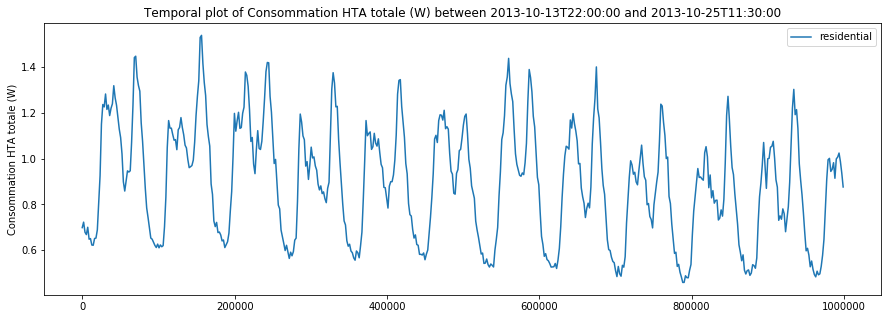

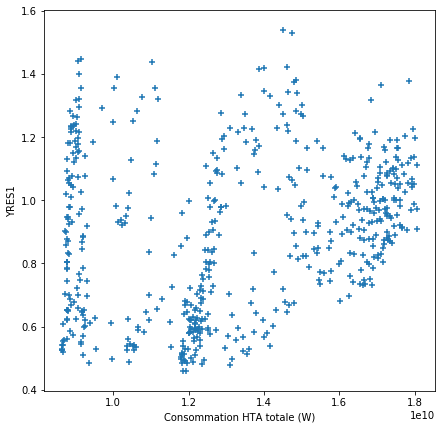

In [94]:
# PLOT DATA
min_t = 0
max_t = 1e6
x_id = 23
y_id = 1

plt.figure(figsize=(15, 5))
min_id_com = next(x[0] for x in enumerate(x_com[:, 1]) if x[1] >= min_t)
max_id_com = next(x[0] for x in enumerate(x_com[:, 1]) if x[1] >= max_t)
vis.plot_time(x_com[min_id_com:max_id_com, 1], y_com[min_id_com:max_id_com, y_id], label_x='YCOM{}'.format(y_id), label_curve='commercial')
min_id_res = next(x[0] for x in enumerate(x_res[:, 1]) if x[1] >= min_t)
max_id_res = next(x[0] for x in enumerate(x_res[:, 1]) if x[1] >= max_t)
vis.plot_time(x_res[min_id_res:max_id_res, 1], y_res[min_id_res:max_id_res, y_id], label_x='YRES{}'.format(y_id), label_curve='residential')
plt.legend(loc='best')
plt.savefig('week_data.png')
plt.show()

plt.figure(figsize=(7, 7))
vis.plot_series(x_res[min_id_res:max_id_res, x_id], y_res[min_id_res:max_id_res, y_id], 
                label_a=x_labels[x_id], label_b='YRES{}'.format(y_id))
plt.show()

In [4]:
# TODO: Fourier seasonal model 
max_id = 48*365*3
# plt.plot(x_res[:max_id, 1], y_res[:max_id, 0])
f = np.fft.fft(y_res[:max_id, 0])
af = np.absolute(f)

trunc = 4
trunc = af.shape[0]
# n_total = 100000
season = np.fft.ifft(f[:trunc], n=n_total)

plot_min = 0
plot_max = 50000

def val(x, spectrum):
    s = 0
    for i in range(spectrum.shape[0]):
        s += spectrum[i].real * np.cos(i*x) + spectrum[i].imag * np.sin(i*x)
    return s

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 7))
ax1.plot(x_res[:max_id, 1], y_res[:max_id, 0])
ax1.set_title('temporal plot of the output value')
ax2.plot(af)
ax2.set_title('spectrogram of the output signal')
ax3.plot(y_res[:, 0])
x_ = np.arange(0, 1.5e8, 1e7)
# ax3.plot(x_, [val(x, f[:trunc]) for x in x_])
ax3.plot(season)

ax4.plot(af[:trunc])
ax4.set_title('Truncated spectrogram of the signal')
plt.show()

NameError: name 'n_total' is not defined

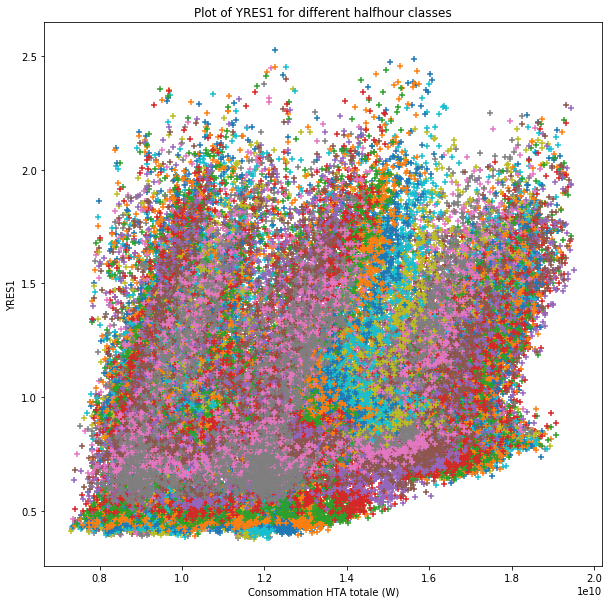

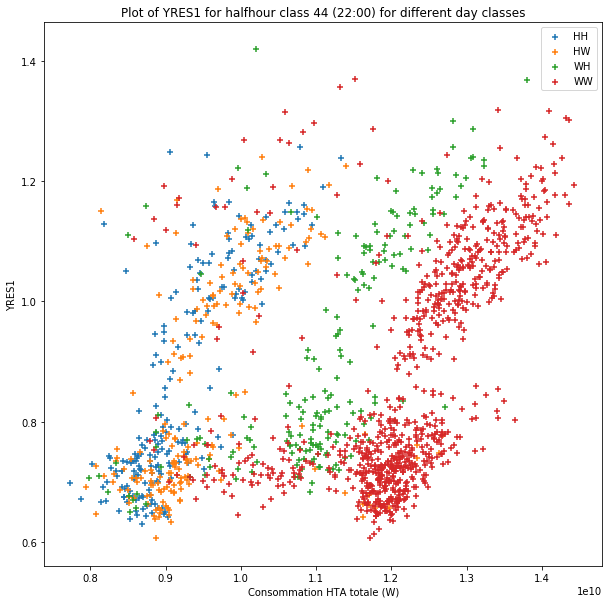

In [35]:
min_id = 0
max_id = n_res

plt.figure(figsize=(10, 10))
for k in range(48):
    vis.plot_series(x_res[min_id+k:max_id:48, x_id], y_res[min_id+k:max_id:48, y_id])
plt.xlabel(x_labels[x_id])
plt.ylabel('YRES{}'.format(y_id))
plt.title('Plot of YRES{} for different halfhour classes'.format(y_id))
plt.show()

plt.figure(figsize=(10, 10))
vis.plot_dayclass(x_res, y_res, x_labels, x_id, y_id, min_id, max_id)
date = datetime.datetime.fromtimestamp(x_res[min_id, 1] + min_timestamp)
h, m = date.hour, date.minute
plt.title('Plot of YRES{} for halfhour class {} ({:02d}:{:02d}) for different day classes'.format(y_id,
                                                                                                  h*2+(m//30),
                                                                                                  h, m))
plt.savefig('HTA_dayclass_{}_{}.png'.format(x_id, y_id))
plt.show()

Proportion of the validation set: 12.3%


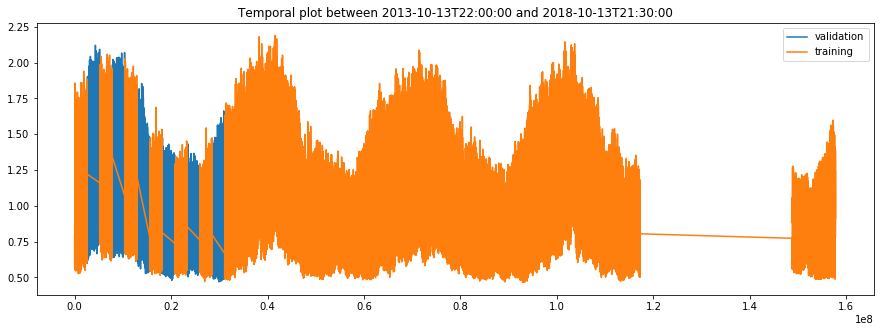

In [6]:
# SEPARATE TRAINING/VALIDATION SETS
is_valid_res = data.separate_x_res(n_res)

plt.figure(figsize=(15, 5))
vis.plot_train_val(x_res, y_res, y_id, is_valid_res, x_labels)
plt.show()

Proportion of the validation set: 10.0%


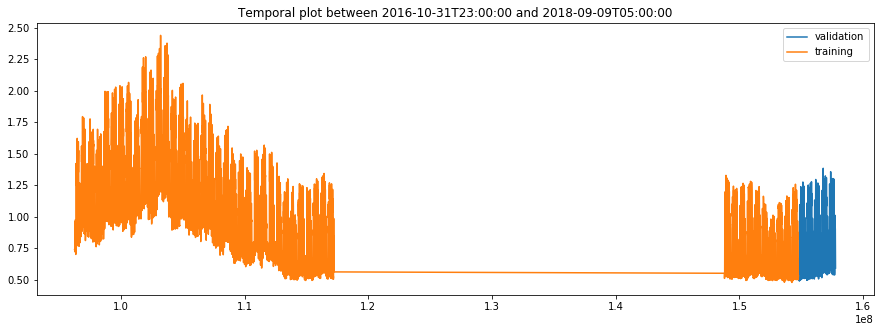

In [7]:
is_valid_com = data.separate_x_com(n_com)

plt.figure(figsize=(15, 5))
vis.plot_train_val(x_com, y_com, y_id, is_valid_com, x_labels)
plt.show()

In [8]:
feats_res = data.create_features(x_res)
feats_com = data.create_features(x_com)

In [9]:
x_train_res, y_train_res, hh_train_res, x_valid_res, y_valid_res, hh_valid_res, id_train_res, id_valid_res = data.create_sets(feats_res, x_res, y_res, is_valid_res)
x_train_com, y_train_com, hh_train_com, x_valid_com, y_valid_com, hh_valid_com, id_train_com, id_valid_com = data.create_sets(feats_com, x_com, y_com, is_valid_com)

In [10]:
# NORMALIZE DATA
scaler = StandardScaler()
scaler.fit(x_train_res)
x_train_res_norm = scaler.transform(x_train_res)
x_valid_res_norm = scaler.transform(x_valid_res)
x_train_com_norm = scaler.transform(x_train_com)
x_valid_com_norm = scaler.transform(x_valid_com)

In [25]:
# TRAIN MODEL
models_res = net.train_models(x_train_res_norm, y_train_res, hh_train_res)
models_com = net.train_models(x_train_com_norm, y_train_com, hh_train_com)

In [27]:
# SAVE MODEL
for i in tqdm.tqdm_notebook(range(48)):
    loader.saveModel(models_res[i], 'models/ckpt_res_{}'.format(i))
    loader.saveModel(models_com[i], 'models/ckpt_com_{}'.format(i))

In [29]:
# PREDICT VALIDATION Y
y_valid_pred_res = net.predict_multi(models_res, x_valid_res_norm, hh_valid_res)
y_valid_pred_com = net.predict_multi(models_com, x_valid_com_norm, hh_valid_com)

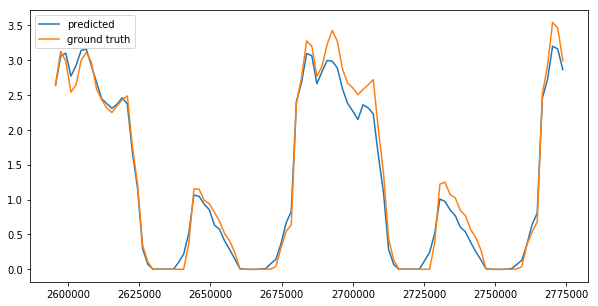

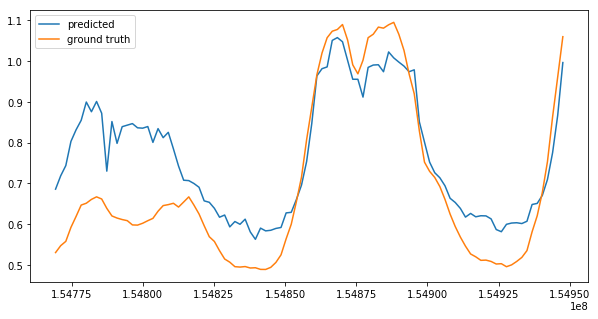

In [34]:
t_valid = x_res[id_valid_res, 1]
t_valid = t_valid[:100]
y_valid_pred = y_valid_pred_res[:100, 2]
y_valid_gt = y_valid_res[:100, 2]
plt.figure(figsize=(10,5))
plt.plot(t_valid, y_valid_pred, label='predicted')
plt.plot(t_valid, y_valid_gt, label='ground truth')
plt.legend(loc='best')
plt.show()

t_valid = x_com[id_valid_com, 1]
t_valid = t_valid[:100]
y_valid_pred = y_valid_pred_com[:100, 0]
y_valid_gt = y_valid_com[:100, 0]
plt.figure(figsize=(10,5))
plt.plot(t_valid, y_valid_pred, label='predicted')
plt.plot(t_valid, y_valid_gt, label='ground truth')
plt.legend(loc='best')
plt.show()

Error analysis for RES:
SE for Y0: 0.0073
SE for Y1: 0.0107
SE for Y2: 0.0228
SE for Y3: 0.0151
MSE RES: 0.01398
Mean relative error: 1.35%


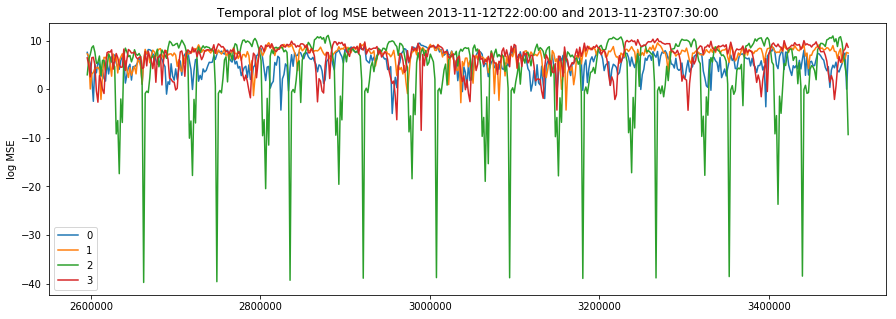

Error analysis for COM:
SE for Y0: 0.0080
SE for Y1: 0.0078
SE for Y2: 0.0053
MSE RES: 0.00704
Mean relative error: 0.88%


In [31]:
print('Error analysis for RES:')
vis.score(y_valid_pred_res, y_valid_res, plot=True, x=x_res, id_valid=id_valid_res)
print('Error analysis for COM:')
vis.score(y_valid_pred_com, y_valid_com)

In [65]:
import numpy as np


def predict_mc(models, X_test, hh_test):
    nS = 100  # Number of Monte Carlo samples
    _, n_out = models[0].get_layer(index=-1).output.shape
    Y_test = np.zeros((nS, X_test.shape[0], n_out))
    for i in tqdm.tqdm_notebook(range(48)):
        ind = np.where(hh_test == i)[0]
        X_test_hh = X_test[ind]
        MC_output = K.function([models[i].layers[0].input, K.learning_phase()], [models[i].layers[-1].output])
        learning_phase = True  # use dropout at test time
        MC_samples = [MC_output([X_test_hh, learning_phase])[0] for _ in range(nS)]
        MC_samples = np.array(MC_samples)
        # print('Testing model {:2d}/{} on {} samples'.format(i+1, 48, ind.shape[0]))
        Y_test[:, ind] = MC_samples
    return Y_test

y_valid_mc = predict_mc(models_res, x_valid_res_norm[:400], hh_valid_res[:400])

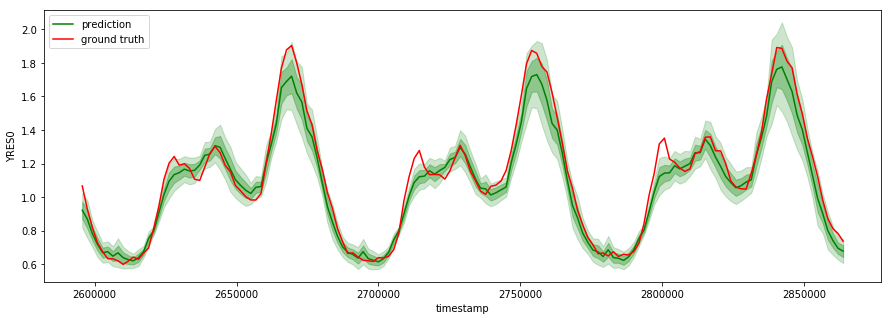

In [82]:
y_target = y_valid_mc[:, :150]
nS, n_ex, n_out = y_target.shape
y_id = 0
y_gt = y_valid_res[:n_ex]
y_pred = np.zeros(n_ex, np.float)
std = np.zeros(n_ex, np.float)
for i in range(n_ex):
    y_pred[i] = np.mean(y_target[:, i, y_id])
    std[i] = np.std(y_target[:, i, y_id])
    # print(y_valid_mc[:, i, y_id])
    # print(std)
t = x_res[id_valid_res, 1]
t = t[:n_ex]

plt.figure(figsize=(15, 5))

# plt.fill_between(t, y_pred-3*std, y_pred+3*std, alpha=.1, color='g')
plt.fill_between(t, y_pred-2*std, y_pred+2*std, alpha=.2, color='g')
plt.fill_between(t, y_pred-std, y_pred+std, alpha=.3, color='g')
plt.plot(t, y_pred, color='g', label='prediction')
plt.plot(t, y_gt[:, y_id], color='r', label='ground truth')
plt.legend(loc='best')
plt.xlabel('timestamp')
plt.ylabel('YRES{}'.format(y_id))
plt.savefig('bayesian.png')
plt.show()

In [ ]:
x_test, entry_list = loader.load_test(test_file_feat='testing_input_BcjTmnd.csv')
n_test = x_test.shape[0]
feats_test = data.create_features(x_test)
feats_test_norm = scaler.transform(feats_test)
hh_test = np.zeros(n_test, dtype=np.int)
for i in range(n_test):
    t = x_test[i, 1]
    date = datetime.datetime.fromtimestamp(t+min_timestamp)
    h, m = date.hour, date.minute
    n = h * 2 + (m // 30)
    hh_test[i] = n
y_res_pred = net.predict_multi(models_res, feats_test_norm, hh_test)
y_com_pred = net.predict_multi(models_com, feats_test_norm, hh_test)
print(y_res.shape)

In [ ]:
# TODO: loader test data and compute test features
# TODO: generate test output
s = 'IDS,Horodate_UTC,Horodate,Mois,RES1_BASE,RES11_BASE,PRO1_BASE,RES2_HC,RES2_HP,PRO2_HC,PRO2_HP\n'
for i in range(n_test):
    l = []
    l.append(entry_list[i][0])
    l.append(entry_list[i][1])
    l.append(entry_list[i][2])
    l.append(entry_list[i][3])
    l.append(str(y_res[i, 0]))
    l.append(str(y_res[i, 1]))
    l.append(str(y_com[i, 0]))
    l.append(str(y_res[i, 2]))
    l.append(str(y_res[i, 3]))
    l.append(str(y_com[i, 1]))
    l.append(str(y_com[i, 2]))

    s += ','.join(l) + '\n'
with open('output.csv', 'w') as f:
    f.write(s)